# Web Speed Trends
<p style='font-size:1.2em'> Ethan Swan </p>

### Setup
For three 7-day periods (*not* starting at the same time each week), I ran a python script that measured my home internet speed exactly once per hour and recorded the output in a sqlite database.
The script ran on a Raspberry Pi in my apartment.
I did not alter my regular behavior during this time, so presumably the measurements are altered by my video streaming habits.
You might say that's fairly unscientific; I might say that I'm not giving up my consumption of the NBA for three weeks.

Enjoy the ride.

In [1]:
# Imports
import sqlite3
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
# Pull in the data
con = sqlite3.connect('data.db')
speeds = pd.read_sql('SELECT * FROM data', con)

Okay, so we have our data. Let's take a look at it.

In [3]:
speeds.head()

,upload,download,ping,timestamp
0,13083797.443421926,2018-02-12T00:06:34.206832Z,7760595.926517854,42.011
1,13360250.885051023,2018-02-12T00:07:32.157422Z,9432117.729862094,39.1
2,13565831.228703678,2018-02-12T00:08:31.845856Z,9392179.93813191,36.811
3,12628749.555523034,2018-02-12T00:11:09.122278Z,9302210.991833623,35.046
4,9144189.487892594,2018-02-12T01:11:09.431576Z,9434854.579579351,39.62


Immediately, it's obvious that the columns are mixed up. Download speeds are almost always faster than upload speeds, the timestamp columns should have timestamps in it, and the smallest numbers (42.011, 39.1) are clearly ping latency in milliseconds. Evidently I was sloppy in my original speed-testing script.

Let's rename the columns appropriately: download, timestamp, upload, and ping.

In [4]:
speeds.columns = ['download', 'timestamp', 'upload', 'ping']
speeds.head()

,download,timestamp,upload,ping
0,13083797.443421926,2018-02-12T00:06:34.206832Z,7760595.926517854,42.011
1,13360250.885051023,2018-02-12T00:07:32.157422Z,9432117.729862094,39.1
2,13565831.228703678,2018-02-12T00:08:31.845856Z,9392179.93813191,36.811
3,12628749.555523034,2018-02-12T00:11:09.122278Z,9302210.991833623,35.046
4,9144189.487892594,2018-02-12T01:11:09.431576Z,9434854.579579351,39.62


With that straightened out, let's do some other cleanup. Upload and download speeds should be in mbps (megabits per second) as opposed to bps (bits per second). And timestamp should be a timestamp value, not just a string.

In [5]:
speeds['timestamp'] = pd.to_datetime(speeds['timestamp'])
for colname in ['upload', 'download']:
    speeds[colname] = speeds[colname].astype(np.float) / 1000000

speeds.head()

,download,timestamp,upload,ping
0,13.083797,2018-02-12 00:06:34.206832,7.760596,42.011
1,13.360251,2018-02-12 00:07:32.157422,9.432118,39.1
2,13.565831,2018-02-12 00:08:31.845856,9.392180,36.811
3,12.628750,2018-02-12 00:11:09.122278,9.302211,35.046
4,9.144189,2018-02-12 01:11:09.431576,9.434855,39.62


One other problem lurks here - time zones! Always excruciating.
The times are all stored in UTC (aka the one true time zone), making them 5 hours ahead of Eastern Standard Time, the local standard for me.
Even though the first time is listed as midnight on 12 Feb, I actually kicked off the script at 7pm.
That 5 hour difference will be important when viewing peak internet usage, so we need to correct for it.

In [6]:
speeds['timestamp'] = speeds['timestamp'] - pd.Timedelta(hours=5)
speeds.head()

,download,timestamp,upload,ping
0,13.083797,2018-02-11 19:06:34.206832,7.760596,42.011
1,13.360251,2018-02-11 19:07:32.157422,9.432118,39.1
2,13.565831,2018-02-11 19:08:31.845856,9.392180,36.811
3,12.628750,2018-02-11 19:11:09.122278,9.302211,35.046
4,9.144189,2018-02-11 20:11:09.431576,9.434855,39.62


Before moving on, let's take a look at what dates we have data for, and verify that it's what we expect.

In [7]:
# Make a bar plot of the ping times by date.
alt.Chart(speeds).mark_bar().encode(
    x=alt.X('timestamp:T'),
    y=alt.Y('ping:Q'))

As expected, we seem to have three distinct 7-day periods.

At this point the data looks pretty good. But it isn't [tidy](http://vita.had.co.nz/papers/tidy-data.html) yet - upload, download, and ping are different measurements made in a single observation. Let's melt it.

In [8]:
melted = speeds.melt(id_vars=['timestamp'])
melted.columns = ['timestamp', 'measure', 'value']
melted['value'] = melted['value'].astype(np.float)
melted.head()

,timestamp,measure,value
0,2018-02-11 19:06:34.206832,download,13.083797
1,2018-02-11 19:07:32.157422,download,13.360251
2,2018-02-11 19:08:31.845856,download,13.565831
3,2018-02-11 19:11:09.122278,download,12.628750
4,2018-02-11 20:11:09.431576,download,9.144189


###  Let the Analysis Begin
So a good place to start would be viewing the overall trends for upload speed and download speed (we'll deal with latency later). Let's take a look.

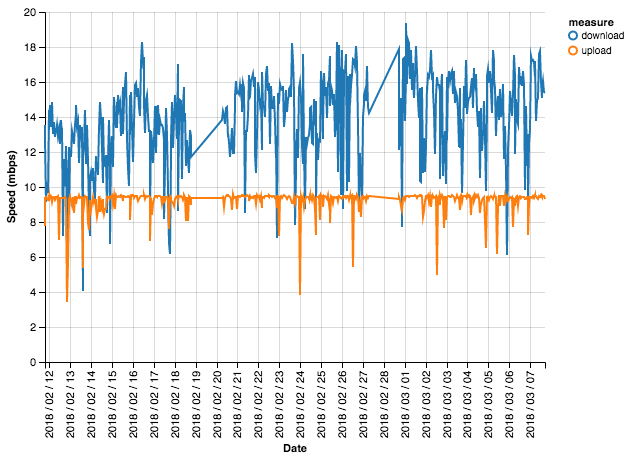

In [22]:
# Keep only upload and download measurements
up_down_speeds = melted.query('measure in ["download", "upload"]')
# Plot
alt.Chart(up_down_speeds).mark_line().encode(
    x=alt.X('timestamp',
            axis=alt.Axis(title='Date',
                          format='%Y / %m / %d',
                          ticks=24)),
    y=alt.Y('value',
            axis=alt.Axis(title='Speed (mbps)')),
    color='measure')

So this data looks noisy, and has big gaps. Let's look at the distributions of upload and download speed.

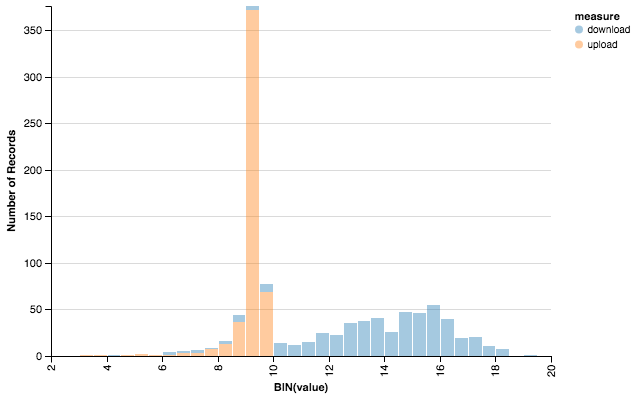

In [72]:
alt.Chart(up_down_speeds).mark_bar(opacity=.4).encode(
    x=alt.X('value', bin=alt.Bin(maxbins=50)),
    y=alt.Y('count(*)'),
    color='measure')

So.... that's kind of weird. Download speeds have a wide distribution, while almost all upload speeds are concentrated in one bin.
But what did we learn about histograms, kids? They're bad. Use density plots instead.

/Users/eswan18/anaconda3/envs/ad_hoc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


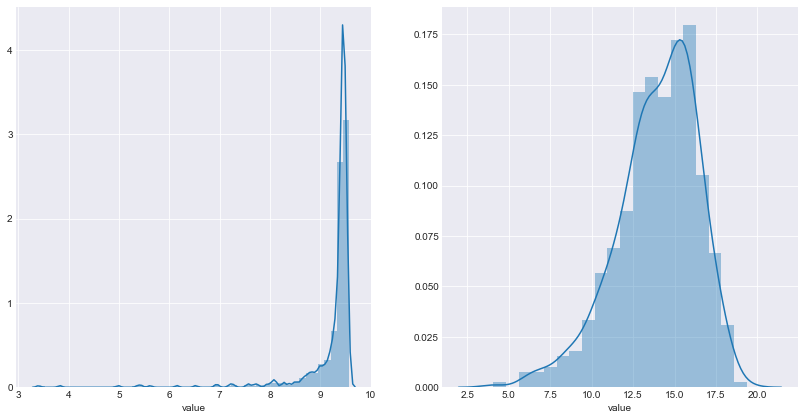

In [11]:
# Alas, it is now that we must turn to Seaborn, for I don't know if this can be done in Altair.
# Set the figure size larger.
figsize(14, 7)
# General yelling: "matplotlib is terrible!!"
# Sadly we need it to create subplots for our side-by-side graphs.
fig, (ax1, ax2) = plt.subplots(ncols=2)
# Draw two distplots, one for upload and one for download
up_speeds = up_down_speeds.query('measure == "upload"')
down_speeds = up_down_speeds.query('measure == "download"')
sns.distplot(up_speeds['value'], ax=ax1)
sns.distplot(down_speeds['value'], ax=ax2)

So just as before, we see that upload speed is highly concentrated between about 9 and 9.5 mbps.
Meanwhile, download speed looks fairly close to normally distributed.
Let's visualize them in a slightly different way, with violin plots.

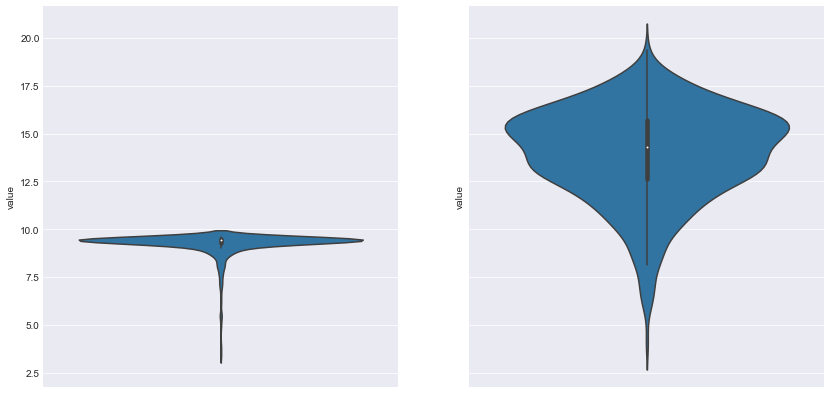

In [12]:
# Same setup as before.
figsize(14, 7)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.violinplot(data=up_speeds, y='value', ax=ax1)
sns.violinplot(data=down_speeds, y='value', ax=ax2)

This time, we forced our plots to share y-axis labels.
We can see that even the maximum upload speed is lower than the average download speed.

So it's about time we start looking at something specific...

### Is web speed meaningfully different by day of week? By hour?
We'll start by separating timestamp into day of week, hour, and minute columns

In [13]:
# Make a copy of the data for this bit.
time_speeds = up_down_speeds.copy()
time_speeds['weekday'] = time_speeds['timestamp'].dt.weekday_name
time_speeds['hour'] = time_speeds['timestamp'].dt.hour
time_speeds['minute'] = time_speeds['timestamp'].dt.minute
time_speeds = time_speeds.drop('timestamp', axis=1)
time_speeds.head()

,measure,value,weekday,hour,minute
0,download,13.083797,Sunday,19,6
1,download,13.360251,Sunday,19,7
2,download,13.565831,Sunday,19,8
3,download,12.628750,Sunday,19,11
4,download,9.144189,Sunday,20,11


First, let's look just at day of week.

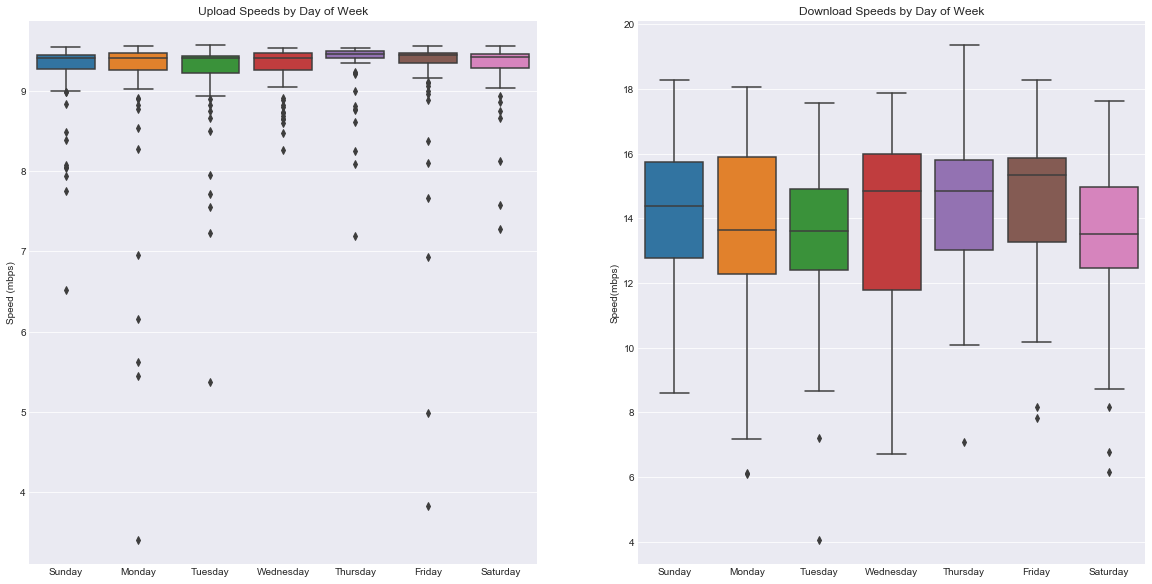

In [14]:
up_time_speeds = time_speeds.query('measure == "upload"')
down_time_speeds = time_speeds.query('measure == "download"')

fig, ax = plt.subplots(ncols=2, figsize=(20, 10), sharey=False)
g = sns.boxplot('weekday', 'value', data=up_time_speeds, ax=ax[0])
g.set(title='Upload Speeds by Day of Week', xlabel='', ylabel='Speed (mbps)')
g2 = sns.boxplot('weekday', 'value', data=down_time_speeds, ax=ax[1])
g2.set(title='Download Speeds by Day of Week', xlabel='', ylabel='Speed(mbps)');

Note that the y-axis values **are not the same**.

To me, it looks like the speeds by day are very similar - very possibly the differences are simply noise. Let's do the same thing, but by hour of the day.

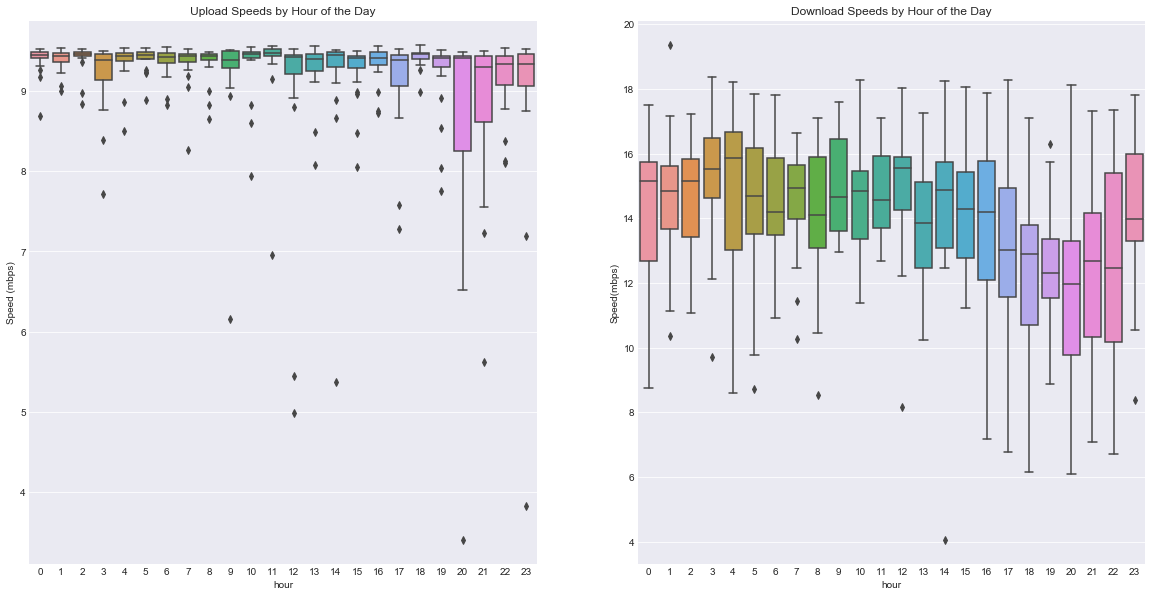

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10), sharey=False)
g = sns.boxplot('hour', 'value', data=up_time_speeds, ax=ax[0])
g.set(title='Upload Speeds by Hour of the Day', ylabel='Speed (mbps)')
g2 = sns.boxplot('hour', 'value', data=down_time_speeds, ax=ax[1])
g2.set(title='Download Speeds by Hour of the Day', ylabel='Speed(mbps)');

On the download graph, it looks like there's definitely a pattern here. Speed dips in the early evening and starts to rise again around 10pm.

What happens if we look at both day and hour simultaneously? We'll do it for download only, since upload seems not to vary much.

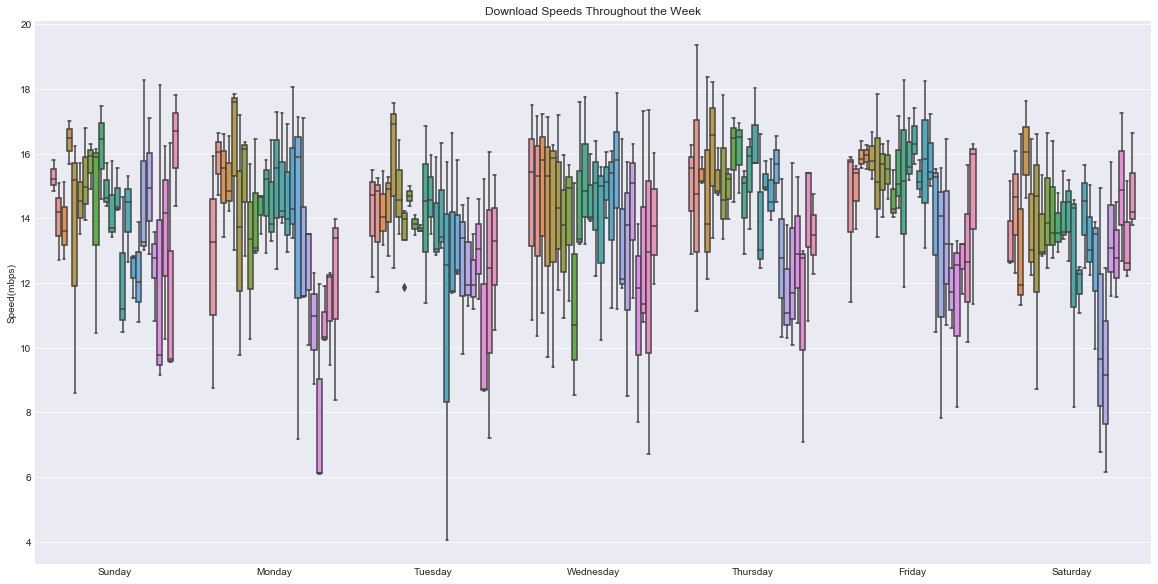

In [16]:
# Create a new column of weekday and hour combined.
#for data in [up_time_speeds, down_time_speeds]:
#    data['week_and_hour'] = 
fig, ax = plt.subplots(ncols=1, figsize=(20, 10))
g = sns.boxplot(x='weekday', y='value', hue='hour', data=down_time_speeds, ax=ax)
g.set(title='Download Speeds Throughout the Week', xlabel='', ylabel='Speed(mbps)')
ax.legend().set_visible(False)

This confirms that the drops in speed during the evening are consistent across days.

At this point, I think there's too much going on to use boxplots - they're making it harder to see patterns. Let's switch back to a simple line following the mean speed at a given weekday/speed.

In [17]:
# Extract just hour and weekday from our data.
hours = down_speeds['timestamp'].dt.hour
weekdays = down_speeds['timestamp'].dt.weekday
# Construct a timestamp from just this information, starting arbitrarily at Jan 1 2018.
timestamps = ['1/%d/2018 %d:00'%(weekday+1, hour) for (weekday, hour) in zip(weekdays, hours)]
# Overwrite the old timestamp column with this new timestamp info.
mod_down_speeds = down_speeds.copy()
mod_down_speeds['timestamp'] = [pd.to_datetime(x) for x in timestamps]
# Take a look.
mod_down_speeds.head()

,timestamp,measure,value
0,2018-01-07 19:00:00,download,13.083797
1,2018-01-07 19:00:00,download,13.360251
2,2018-01-07 19:00:00,download,13.565831
3,2018-01-07 19:00:00,download,12.628750
4,2018-01-07 20:00:00,download,9.144189


**NOTE: This cell doesn't run because of a bug in Altair: https://github.com/altair-viz/altair/issues/424**

In [ ]:
chart = alt.LayeredChart(mod_down_speeds, layers=[
    alt.Chart().mark_line().encode(
        x=alt.X('timestamp:T'),
        y=alt.Y('average(value)')
    ),
    alt.Chart().mark_line().encode(
        x=alt.X('timestamp:T'),
        y=alt.Y('median(value)')
    )])
chart

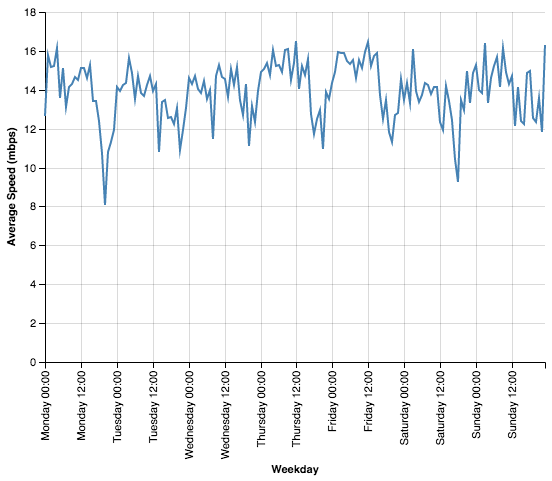

In [31]:
alt.Chart(mod_down_speeds).mark_line().encode(
    x=alt.X('timestamp:T',
            axis=alt.Axis(title='Weekday',
                          format='%A %H:00',
                          ticks=14)),
    y=alt.Y('average(value)', title='Average Speed (mbps)')
)

Okay, this looks pretty noisy but it is helpful. Let's plot a moving average of the average speed to smooth it out.

In [73]:
# First do the groupby and aggreation in mod_down_speeds
roll_down_speeds = mod_down_speeds.groupby('timestamp').mean()[['value']]
roll_down_speeds['timestamp'] = roll_down_speeds.index
# Then create a rolling average column
roll_down_speeds['mvg_value'] = roll_down_speeds['value'].rolling(window=5, center=True, min_periods=1).mean()
roll_down_speeds.head()

,value,timestamp,mvg_value
timestamp,,,
2018-01-01 00:00:00,12.651922,2018-01-01 00:00:00,14.550292
2018-01-01 01:00:00,15.802486,2018-01-01 01:00:00,14.715231
2018-01-01 02:00:00,15.196468,2018-01-01 02:00:00,15.003506
2018-01-01 03:00:00,15.210049,2018-01-01 03:00:00,15.186860
2018-01-01 04:00:00,16.156608,2018-01-01 04:00:00,15.050310


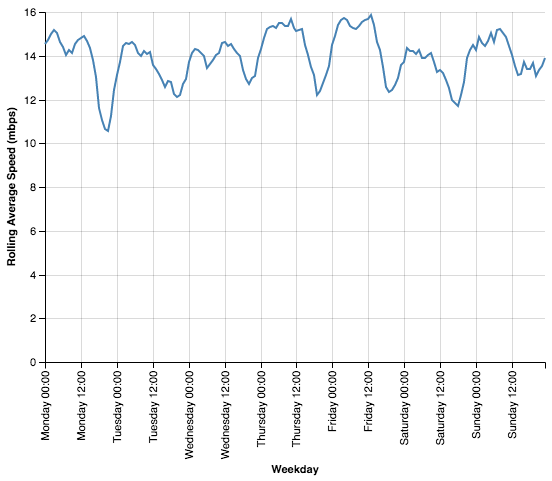

In [74]:
alt.Chart(roll_down_speeds).mark_line().encode(
    x=alt.X('timestamp:T',
            axis=alt.Axis(title='Weekday',
                          format='%A %H:00',
                          ticks=14)),
    y=alt.Y('mvg_value', title='Rolling Average Speed (mbps)')
)

Now this is interesting! We consistently see a local minimum at about 6-8pm, but the speed at that time is very different by weekday. Tuesday and Wendesday show relatively little fluctation, while the drop in speed on Mondays from noon to evening is precipitous.